## HSBC Data Science project - Recommender System

### Yulin Chen

## Summary

In this project, three recommender systems: 1) [Baseline model](#section_bm); 2) [User-User Collaborative Filtering model](#section_cf); 3) [Truncated SVD model](#section_tsvd) are constructed and compared using the one month User-Item data from 11/18/2014 to 12/18/2014.

First, by [Exploratory Data Analysis (EDA) and processing](#section_eda), data are splitted into training and validation sets by the ratio of 7/3 under time sequence. In the data processing, **two assumptions are made:** 1) score of {1: clicking} doesn't mean the users are interested in the items at all, which means only closer interactions with score > 1 are considered; 2) items appear only in training set and disappear in the validation set means the items have been taken down by the merchants and it won't appear any more in the future. Under these consumptions, the size of training data is largely reduced, making the model training process executable locally and efficiently. Meanwhile, cold start items that are only in the validation instead of training set are not considered.

Apart from this, several technical processing are conducted. Because both the [User-User Collaborative Filtering model](#section_cf) and [Truncated SVD](#section_tsvd) need a _utility matrix_, which is a very sparse matrix with user_id as rows, item_id as columns, and score as the values. Hence, [row based Linked List (lil) sparse matrix](#section_lil) is employed to better construct and store the sparse data. Meanwhile, in order to realize efficient indexing, the original user_id and item_id are [hashed](#section_hash) using data structure of _dictionary_ in Python.

In terms of the [metrics](#section_metrics) for evaluation, there are mainly two parts. One is the error evaludation for score/rating using MAE and RMSE. The other is the evaludation of list of recommendations using precision, recall and F1-score.

To implement the recommendation system contruction, [User-User based Collaborative Filtering model](#section_cf) is first constructed. Because the number of the unique user_id is much less than the item_id, User based similarity matrix is calculated instead of using the Item-based matrix. Meanwhile, the cosine similarity is applied as the similarity definition. The similarity weighted score for the missing rating of a user is estimated by using the similarity between the user and his/her nearest neighbors, and the neighbor's rated scores.  Then, a [Truncated SVD model](#section_tsvd), which is one of the low rank matrix approximation type methods, is used to predict all the missing value by converting the sparse utility matrix to a dense matrix. Herein, 1000 principle components are used to count around 50% cumulative explained variance due to the consideration of memory and time resources for the processing. As a bonus in this project, a baseline model is built. Actually, there are two versions. [One](#section_bm) is to recommend 5 most popular unrated items in the category that the user mostly interacted with. [The other](#section_bmave) is to estimate rating using the average scores of the user in the training data. The latter is mainly used in the validation section to compare with the other two models.

[Evaluation](#section_eva) is implemented using the validation data.  In total, there are around 60000 rated pairs of (user_id, item_id) in the validation set and not ever in the training set. 10000 pairs are randomly selected from them to evaluate MAE, RMSE and average F1 score. In the results, it shows that the User collaborating filtering model has way better performance than the Truncated SVD model that only counts 50% cumulated variance in this project. However, the current version of User-based model behaves a bit worse than the [baseline model](#section_bmave) due to the very sparse data.

## Contents

### **1. [Exploratory Data Analysis (EDA) and Processing](#section_eda)**
### **2. [Evaluation Criteria](#section_crit)**
### **3. [Recommendation System](#section_lil)**
>  **3.1 [User-User Collaborative Filtering model](#section_cf)**<br>
>  **3.2 [Truncated SVD Model](#section_tsvd)**<br>
>  **3.3 [Baseline Model](#section_bm)**
### **4. [Evaluation](#section_eva)**

 
 <a href='#section_crit'></a>
 <a href='#section_cf'></a>
 <a href='#section_bm'></a>
 <a href='#section_tsvd'></a>
 <a href='#section_lil'></a>
 <a href='#section_hash'></a>
 <a href='#section_metrics'></a>
 <a href='#section_bmave'></a>
 <a href='#section_eva'></a>

In [260]:
import numpy as np
import pandas as pd
import json

import random
from collections import defaultdict
from scipy import sparse
import scipy.sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_recall_curve

from time import time
import gc
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['lines.linewidth'] = 2
%matplotlib inline 

 <a id='section_eda'></a>
## 1. Exploratory data analysis (EDA) and processing

In [2]:
# Read data
df_user = pd.read_csv('user_behaviour_complete.csv')
df_item = pd.read_csv('item_metadata.csv')

__Now, we need to merge the 'item_location_hash' from item table to the user table. Herein, the left join is used based on the columns of 'item_id' in user table.__

In [3]:
df = df_user.merge(df_item.drop(columns='item_cat'), how = 'left', on = 'item_id')
del df_user, df_item
gc.collect()

39

__The printing below shows there are 8898 item categories in total.__

In [5]:
df['item_category'].nunique()

8898

__Change the column of 'time' to datetime type and use it as index for the dataframe. Meanwhile, the data is sequentially sorted acendingly by 'time' and 'user_id', and descendingly by 'behavior_type'. We can see it is the one month data from 2014-11-18 to 2014-12-18 with 13670706 rows, which also means the purchasing platform is very active among users. From the plot, we can see only 12-12 has more interaction and others are under similar levels.__

In [56]:
# Change datatype of 'time' to datetime
df['time'] = pd.to_datetime(df['time'])
# Sort data acendingly by time, user_id, and descendingly behavior_type by the sequence
df.sort_values(['time', 'user_id', 'behavior_type'], ascending=[True, True, False],inplace = True)
df.set_index('time', inplace = True) # Set index with time

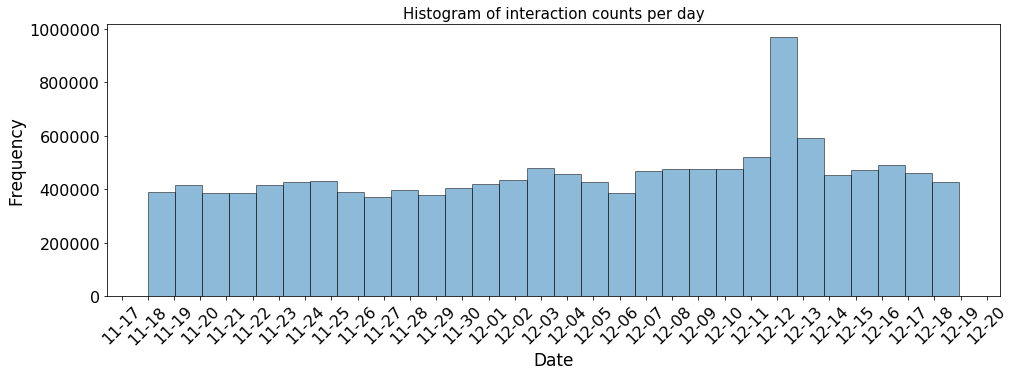

In [87]:
fig, ax = plt.subplots(figsize=(16,5))
ax.hist(df.index,bins=30,alpha=0.5,histtype='bar',ec='black')
ax.set_xlabel('Date',fontsize=17)
ax.set_ylabel('Frequency',fontsize=17)
ax.set_title('Histogram of interaction counts per day', fontsize = 15)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
# Format the x axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
plt.show()

__By printing the missing value, it shows no missing value exists in the 'behavior_type'. Most user and item hashed location information is missing.__

In [7]:
pd.isnull(df).sum()

user_id                      0
item_id                      0
behavior_type                0
user_location_hash     9255016
item_category                0
item_location_hash    12300593
dtype: int64

__We can see the unique user number is much smaller than the item number.__

In [16]:
print('Unique number of users: %i' % df['user_id'].nunique())
print('Unique number of items: %i' % df['item_id'].nunique())

Unique number of users: 10000
Unique number of items: 2914411


__Plot the histogram to see the number of user interation activities. It denotes that most users heavily involve in this online platform based on the annual data. There are around 50% users with more than 700 activities in 2014.__

In [17]:
# Counts of user interactions
df_user_counts=df['user_id'].value_counts()
df_user_counts.head()

51003537     68813
67972803     35390
53181951     34968
124471795    34343
89634823     30740
Name: user_id, dtype: int64

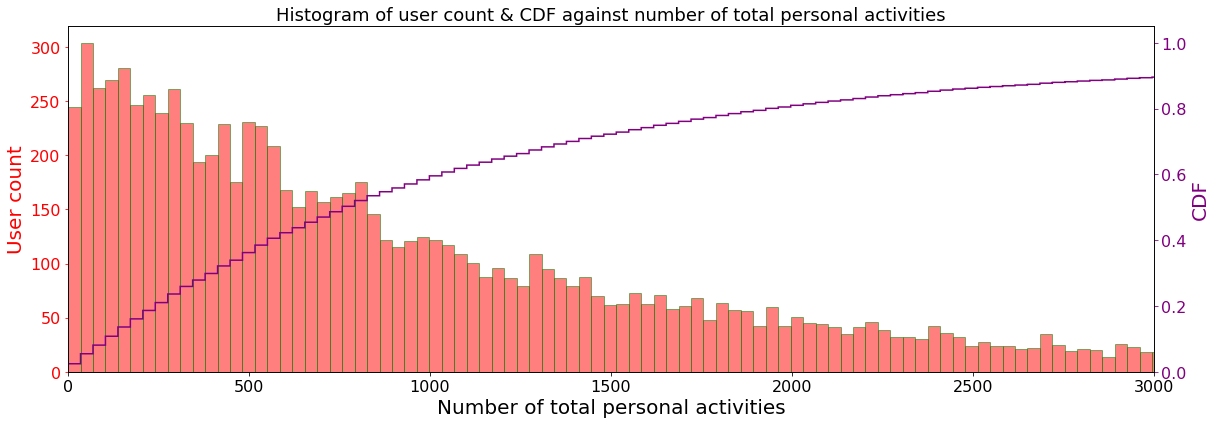

In [18]:
fig, ax = plt.subplots(figsize=(17,6))
lns1 = ax.hist(df_user_counts.values,bins=2000,alpha=0.5,histtype='bar',ec='green',color='r')
ax.set_xlabel('Number of total personal activities')
ax.set_ylabel('User count', color='r')
ax.tick_params(axis='y',colors='r')
ax.set_xlim(0,3000)
ax.set_title('Histogram of user count & CDF against number of total personal activities')

ax2 = ax.twinx()
lns2 = ax2.hist(df_user_counts.values, bins = 2000, histtype='step',color='purple', cumulative=True, 
         linewidth = 1.5, normed=True)
ax2.set_ylabel('CDF', color = 'purple')
ax2.tick_params(axis='y',colors='purple')

fig.tight_layout()
plt.show()

__However, we know the data is very imbalanced that most users have the behavior of '1: click' by the printout below. However, compared to the other three behaviors, clicking generally means the user is simply browsing to see if the item matches his or her tastes.  Thus, we need to further analyze the user with closer interaction, which means they do: {2: add to wishlist', 3: 'add to cart', 4: 'pay'}.__

__It shows 96.5% users have closer interaction. Among them, 68.6% for 'add to wishlist', 86.9% for 'add to cart', 88.7% for 'pay'. With the similar plot above, it shows around 50% of total users have more than 30 times closer interactions in 2014.__

In [19]:
print('User behavior type count based on activities:')
df_bhv_counts=df['behavior_type'].value_counts()
df_bhv_counts.head()

User behavior type count based on activities:


1    12907307
3      393511
2      239837
4      130051
Name: behavior_type, dtype: int64

In [4]:
mask = df['behavior_type']!=1 # filter with closer interaction
mask_2 = df['behavior_type']==2 # filter with 'add to wishlist'
mask_3 = df['behavior_type']==3 # filter with 'add to cart'
mask_4 = df['behavior_type']==4 # filter with 'pay'
user_cnt_closer = df[mask]['user_id'].nunique() # count the unique user with closer interaction
user_cnt_2 = df[mask_2]['user_id'].nunique() # count the unique user with 'add to wishlist'
user_cnt_3 = df[mask_3]['user_id'].nunique() # count the unique user with 'add to cart'
user_cnt_4 = df[mask_4]['user_id'].nunique() # count the unique user with 'pay'
print('There are %i users with closer interation, accounting for %.1f%% of total users.'
      % (user_cnt_closer, user_cnt_closer/df['user_id'].nunique()*100))
print('-'*80)
print('There are %i users with add to wishlist, accounting for %.1f%% of total users.'
      % (user_cnt_2, user_cnt_2/df['user_id'].nunique()*100))
print('There are %i users with add to cart, accounting for %.1f%% of total users.'
      % (user_cnt_3, user_cnt_3/df['user_id'].nunique()*100))
print('There are %i users with payment, accounting for %.1f%% of total users.'
      % (user_cnt_4, user_cnt_4/df['user_id'].nunique()*100))

There are 9650 users with closer interation, accounting for 96.5% of total users.
--------------------------------------------------------------------------------
There are 6861 users with add to wishlist, accounting for 68.6% of total users.
There are 8689 users with add to cart, accounting for 86.9% of total users.
There are 8867 users with payment, accounting for 88.7% of total users.


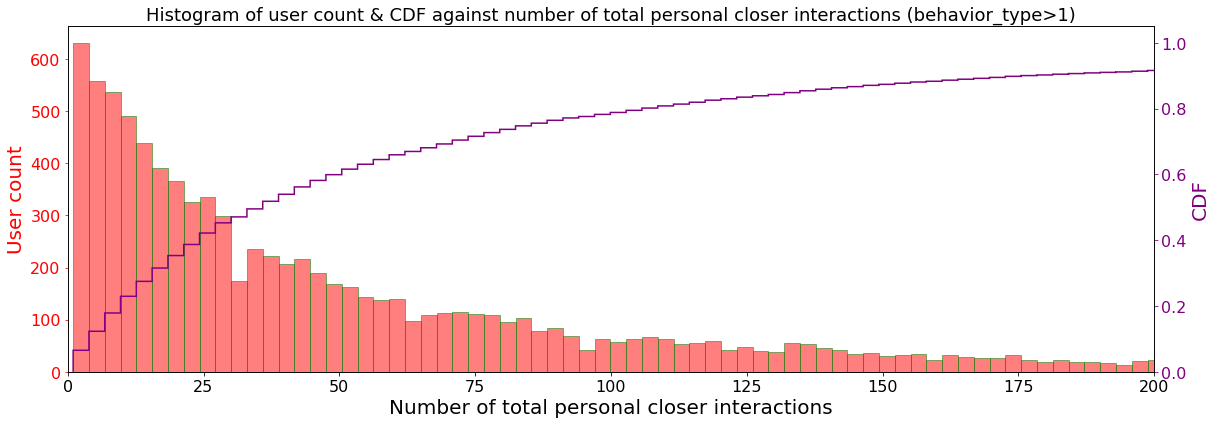

In [21]:
df_closer_cnt = df[mask]['user_id'].value_counts()
fig, ax = plt.subplots(figsize=(17,6))
lns1 = ax.hist(df_closer_cnt.values,bins=3000,alpha=0.5,histtype='bar',ec='green',color='r')
ax.set_xlabel('Number of total personal closer interactions')
ax.set_ylabel('User count', color='r')
ax.tick_params(axis='y',colors='r')
ax.set_xlim(0,200)
ax.set_title('Histogram of user count & CDF against number of total personal closer interactions (behavior_type>1)')

ax2 = ax.twinx()
lns2 = ax2.hist(df_closer_cnt.values, bins = 3000, histtype='step',color='purple', cumulative=True, 
         linewidth = 1.5, normed=True)
ax2.set_ylabel('CDF', color = 'purple')
ax2.tick_params(axis='y',colors='purple')

fig.tight_layout()
plt.show()

__Currently, there are 13670706 rows in the data, which is too heavy to be processed with useless data. To reduce the size of it, rows with clicking activities are removed since clicking doesn't mean the user has strong interests in it. Also, the removed rows include all inactive users and unpopular items that are only with clicking. It shows 763399 rows are kept by removing 94.4% rows. In total, 9650 users and 448856 items are retained.__

In [5]:
df = df[mask] # Use the mask created above considering closer interaction
print(str('%i rows left with %.1f%% rows removed from the original data.'
          %(df.shape[0],(1-df.shape[0]/13670706)*100)))

763399 rows left with 94.4% rows removed from the original data.


In [6]:
print('The retained number of users: %i' % df['user_id'].nunique())
print('The retained number of items: %i' % df['item_id'].nunique())

The retained number of users: 9650
The retained number of items: 448856


In [7]:
# Remove the hashed location of both users and items due to mostly missed value
df.drop(columns=['user_location_hash', 'item_location_hash'], inplace=True)
df.to_csv('data_proc.csv') # save the processed data

<a id='section_crit'></a>
## 2. Evaluation criteria

In order to evaluate the performance of the recommender system, we split the data by the ratio of __7:3__ by the time sequence. First, the __assumption__ is made that items with closer interaction ('behavior_type'>1) only in training and not in validation sets have been taken down by the merchant. It is common in reality such as the coupons or tickets only for sale before its happening, or the commodities have been sold out, etc. So in this case, they are not allowed to have closer interactions but can probably be clicked through by telling they are invalid. 

As a result, only retain items exist in both training and validation sets. Another reason is that items only in validation set mean they are cold starter/new items. Furthermore, evaluation can be better implemented. The smaller training dataset can provide more efficient recommending processes. Similarly, users only in validation data are removed since they are cold starter. In this test, cold start users will be recommended with the top five items with the highest sum of 'behavior_type'.

In [17]:
# Split data
mask = int(df.shape[0]*0.7)
df_train = df[:mask]
df_val = df[mask:]
print('Rows of Train data: %i' % df_train.shape[0])
print('Rows of Validation data: %i' % df_val.shape[0])

Rows of Train data: 534379
Rows of Validation data: 229020


In [19]:
# Item list to be retained
item_list = set(df_val['item_id']) & set(df_train['item_id'])
# Mask for train data
mask_train = np.isin(df_train['item_id'], list(item_list))
# Retain rows in train
df_train = df_train[mask_train]

# Item mask for validation data
mask_val_item = np.isin(df_val['item_id'], list(item_list))

# User mask for validation data by removing new start users
user_remove_list = set(df['user_id']) - set(df_train['user_id'])
mask_val_user = ~np.isin(df_val['user_id'], list(user_remove_list))
mask_val = mask_val_item & mask_val_user
df_val = df_val[mask_val]
print('Rows of Train data: %i' % df_train.shape[0])
print('Rows of Validation data: %i' % df_val.shape[0])

Rows of Train data: 163805
Rows of Validation data: 112463


In [20]:
# Save processed data
df_train.to_csv('data_train.csv')
df_val.to_csv('data_val.csv')

 <a id='section_metrics'></a>
In terms of the metrics, there are mainly two sections. The short list is below:
 - __Evaluating error of score/rating:__
     - __MAE__
     - __MSE__
     - __RMSE__

 - __Evaluating list of recommendation (based on relevancy levels):__ 
     - __Precision, Recall and F1 score:__ Suitable for imbalanced data
     - __Receiver Operating Characteristic (ROC) curve:__ False positive rate (x-axis) vs. the true positive rate (y-axis). It is not suitable for imbalanced data
     - __Mean Average Precision (MAP):__ Summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve
     - __Area under curve (AUC):__ Summarizes the integral or an approximation of the area under the precision-recall or ROC curve

In this test, error validation is conducted using MAE and RMSE by comparing the original and predicted rating using the validation set.

Moreover, the list of recommendation is evaluated using __Precision__ and __Recall__. Due to the data analysis in Part 1, the data is highly imbalanced with most scores of {1: Clicking}, aka. the high true negative. It makes sense in the real markets that most people only have interaction with small number of items. Thus, precision and recall are selected as the metrics since they work well in the imbalance. The reason is that both precision and recall don't make use of __true negative__ (the grey color region below, sourse: _Wikipedia_), which stands for the unrecommended items in this test. A problem with recall and precision is that usually, recall increases as predicted recomendation size is increased while precision decreases as the is increased. Thus, F1 score is used to balance this trade-off effect.

For each user, the definition of the three metrics are:

__Recall__ = # of relevant recommendations  / # of items we recommend

__Precision__ = # of relevant recommendations / # of all the possible relevant items

__F1__ = (2 * Recall * Precision) / (Recall + Precision)

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png width="300">
<a href='#section1'></a>

In [401]:
def error(predict, true, threshold = 3):
    '''
    Recall = # of relevant recommendations / # of items we recommend
    Precision = # of relevant recommendations / # of all the possible relevant items
    F1 = 2 * Precision * Recall / (Recall + Precision)
    
    Input:
        predict: predicted score
        true: score from validation data
        threshold: the threshold to generate binary classified value
    Output:
        MAE, RMSE, precision, recall, f1
    '''
    
    diff = np.subtract(predict, true)
    mae = np.abs(diff).mean()
    rmse = np.sqrt((np.square(diff).mean()))
    
    # precision and recall
    true_mask = np.array(true)>=threshold
    prec_mask = np.array(predict)>=threshold
    size_hit = (true_mask & prec_mask).sum()
    prec_deno = prec_mask.sum() # denominator of precision
    recall_deno = true_mask.sum() # denominator of recall
    if prec_deno == 0:
        precision = recall = -1
        f1 = -1
    elif recall_deno == 0:
        precision = recall = -1
        f1 = -1
    else:
        precision = size_hit / prec_deno
        recall = size_hit / recall_deno
        f1 = 2 * precision * recall / (precision + recall)
    
    return mae, rmse, precision, recall, f1

 <a id='section_lil'></a>
## 3. Recommender system

In this part, three recommender systems: __1) User-user simililarity collaborative filtering__, __2) Trancated SVD__, and __3) Baseline model based on past user interactions__ are developed.

For models 1) and 2), they both need a utility matrix that is a matrix constructed with full user_id as the row and item_id as the column, which is very sparse. So far, the name of the user_id and item_id are hashed with index meaning. What needs to do is to build it using sparse matrix to save space and time instead of the pivot table that easily causes memory explosion. __Row based Linked List (lil) sparse matrix__ is used here since it is better for contruction and supports flexible slicing. As the contruction based on training data is still a time-consuming process, the built sparse matrix is saved with __Compressed Sparse Row (csr)__ format to be reloaded for recommender systems.
 <a id='section_hash'></a>

__In order to better index, user_id and iterm_id are hashed. Meanwhile, the inversed hash is built as well__.

In [22]:
start_time = time()

# Hash user_id and item_id to easily build sparse matrix
user_hash = {i:j for i, j in zip(df_train['user_id'].unique(), np.arange(df_train['user_id'].nunique()))}
item_hash = {i:j for i, j in zip(df_train['item_id'].unique(), np.arange(df_train['item_id'].nunique()))}

# Inverse hash for later use
user_hash_inv = {i:j for i, j in zip(np.arange(df_train['user_id'].nunique()), df_train['user_id'].unique())}
item_hash_inv = {i:j for i, j in zip(np.arange(df_train['item_id'].nunique()), df_train['item_id'].unique())}

# Hashing. (Map is super faster than replace that is w/ memory explosion)
df_train['user_id'] = df_train['user_id'].map(user_hash) 
df_train['item_id'] = df_train['item_id'].map(item_hash)
df_val['user_id'] = df_val['user_id'].map(user_hash) 
df_val['item_id'] = df_val['item_id'].map(item_hash)

print("Execution time: %f seconds" % (time()-start_time))

Execution time: 0.330176 seconds


In [24]:
start_time = time()
# Construct sparse matrix as the untility matrix for training data.
user_dim = df_train['user_id'].nunique()
item_dim = df_train['item_id'].nunique()
util_mat = sparse.lil_matrix((user_dim, item_dim)) # lil is good at constructing
for _, row in df_train.iterrows(): # Construction takes a little long time, but much better than pivot table
    if util_mat[row.user_id, row.item_id] != 0: # Keep the highest interaction
        util_mat[row.user_id, row.item_id] = max(util_mat[row.user_id, row.item_id], row.behavior_type)
    else:
        util_mat[row.user_id, row.item_id] = row.behavior_type
print("Execution time: %f seconds" % (time()-start_time))

Execution time: 24.059991 seconds


In [25]:
util_mat

<8737x74246 sparse matrix of type '<class 'numpy.float64'>'
	with 108742 stored elements in LInked List format>

In [26]:
# Save the sparse matrix
scipy.sparse.save_npz('sparse_utility_matrix.npz', util_mat.tocsr())

<a id='section_cf'></a>
### 3.1 User-User Similarity Collaborative Filter Recommender

Previous work have saved __1) the processed dataframe with user_id and item_id unhashed__, __2) hash maps__, and __3) utility sparse matrix__. They will be used below by reloading, improving recommender engine efficiency.

After calculating the cosine similarity matrix using the utility matrix, the score $r_{aj}$ of an unrated item j for a specific user a can be estimated from the equation shown below, where _N(a)_ is the nearest neighbor set of user a, and $s_{aj}$ is the similarity between user a and j. In the example case below, the similarity values are assumed with 1.0. In the code implementation, if no neighbors have rated one item, score of zero will be assigned.

<img src=https://image.slidesharecdn.com/recommendersystemnavisroanalytics-120818125400-phpapp02/95/collaborative-filtering-and-recommender-systems-by-navisro-analytics-6-728.jpg?cb\u003d1345294669 width="700">


__Reload data__

In [7]:
start_time = time()

# Reload data
df_train = pd.read_csv('data_train.csv', index_col = 'time')
df_val = pd.read_csv('data_val.csv', index_col = 'time')
df_train.drop(columns='Unnamed: 0', inplace=True)
df_val.drop(columns='Unnamed: 0', inplace=True)

# Load the sparse matrix and convert to lil sparse
util_mat = scipy.sparse.load_npz('sparse_utility_matrix.npz')
util_mat = util_mat.tolil()
# Compute similarity matrix
user_sim_mat = cosine_similarity(util_mat)
item_sim_mat = cosine_similarity(util_mat.T)

# Hash user_id and item_id to easily index
user_hash = {i:j for i, j in zip(df_train['user_id'].unique(), np.arange(df_train['user_id'].nunique()))}
item_hash = {i:j for i, j in zip(df_train['item_id'].unique(), np.arange(df_train['item_id'].nunique()))}

# Inverse hash
user_hash_inv = {i:j for i, j in zip(np.arange(df_train['user_id'].nunique()), df_train['user_id'].unique())}

# Hashing
df_train['user_id'] = df_train['user_id'].map(user_hash) 
df_train['item_id'] = df_train['item_id'].map(item_hash)
df_val['user_id'] = df_val['user_id'].map(user_hash) 
df_val['item_id'] = df_val['item_id'].map(item_hash)

# user_id list, used for check if users are cold starter
list_user = set(df_train['user_id'])
list_item_total = set(df_train['item_id'])

# Recommend list for cold starter (new user) with the most activities
list_ct = df_train['item_id'].value_counts()[:5].index.values

print("Execution time: %f seconds" % (time()-start_time))

Execution time: 6.814404 seconds


__Calculate nearest neighbors respect to the specific user for obtaining weighted scores.__

In [10]:
def knn(id_int, k, sim_mat):
    '''
    Input:
        id_int: the hashed id to be interested. User_id or Item_id
        k: k nearest neighbor to be output
        sim_mat: similarity matrix. Item or User
        
    Ouput:
        k nearest neighbor for user_id
    '''
    pool = np.argsort(sim_mat[id_int])[-k-1:-1] # -1, Since the last one is itself
    return pool[sim_mat[id_int, pool] != 0] # Only return users w/ similarity not 0

__Recommend 5 items for the interested user. Cosine similarity is used to calculate the similarity matrix. Then k nearest neighbor is used to provide the similar users for calculating weighted interaction score. Finally, the 5 items with top weighted scores are recommended.__

In [102]:
# User-User Collaborative Filtering model
def cf_user(user_id, n_items=5,  error=False, user_hash_in=False, item_hash_out=True, user_sim_mat=user_sim_mat):
    '''
    Input:
        user_id: unhashed user_id
        n_items: n items to be recommended, 5 in this project.
        error: boolean to turn on or off the evaluation mode
        user_hash_in: If the input is hashed user_id (0,1,2,...). Default is False
        item_hash_out: If the output needs to be hashed item_id (0,1,2,...). Default is True
        user_sim_mat: User-User similarity matrix
    Ouput:
        return recomended n_items
    '''
    start_time = time()
    
    if not user_hash_in: # if input is unhashed
        user_id = user_hash[user_id] # Get mapped user_id from hash table
    
    # Check if this is a cold starter (new user)
    if user_id not in list_user:
        print('This is a cold start user.')
        return list_ct

    # Consider 100 nearest neighbors, but only nonzero similarity user returned
    nb_users = knn(user_id, 100, user_sim_mat)
    # Initialize the dict storing the pair: (user_id: weighted inteaction score) 
    pool_id = []
    pool_score = []
    # Find items that have been rated by the user
    items_rated = set(util_mat[user_id].nonzero()[1])
    items_unrated = list_item_total - items_rated # difference between two sets
    
    for item_to_pred in items_unrated:
        # Only consider neighbor users w/ closer interaction into calculation
        candidate = np.array(util_mat[nb_users, item_to_pred].todense()).squeeze()
        user_pool = nb_users[candidate>1]
        if len(user_pool) != 0: # ensure at lease one neighbor rated the item
            deno = 0 # denomintor of the score
            score = 0
            # calculating score
            for user in user_pool:
                b = user_sim_mat[user_id, user]
                a = util_mat[user, item_to_pred]
                deno += b
                score += a*b
            score /= deno
            pool_id.append(item_to_pred)
            pool_score.append(score)
                
    # Recommend top n_items by the score
    list_item = np.argsort(pool_score)[-n_items:]
    pool_id = np.array(pool_id)[list_item]
    
    if len(pool_id) < n_items:# if list size < 5, add most popular items
        for i in range(n_items - len(pool_id)):
            pool_id.append(list_ct[i])
    
    if not item_hash_out: # if unhashed item_id is required
        pool_id = [item_hash_inv[i] for i in pool_id]
        
    # Release memory
    del user_sim_mat, nb_users, items_rated
    gc.collect()
    
    print("Execution time: %f seconds" % (time()-start_time))
    
    return pool_id , np.array(pool_score)[list_item]

In [12]:
user_id = user_hash_inv[200] # Pick a lucky user
cf_user(user_id)

Execution time: 6.339402 seconds


(array([55942,  9607,  9584,  9497, 29907]), array([4., 4., 4., 4., 4.]))

<a id='section_tsvd'></a>
### 3.2 Trancated SVD

In the plot below, 500 components can reach explained variance more than 50%. So it is used.

In [248]:
def fit_uvd(M,k):
    start_time = time()
    # use TruncatedSVD to realize UVD
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
    svd.fit(M)

    V = svd.components_
    U = svd.transform(M) # effectively, it's doing: U = M.dot(V.T)
    
    print("Execution time: %f seconds" % (time()-start_time))
    return U,V, svd

# decompose
U,V,svd = fit_uvd(util_mat, 1000)

Execution time: 59.258606 seconds


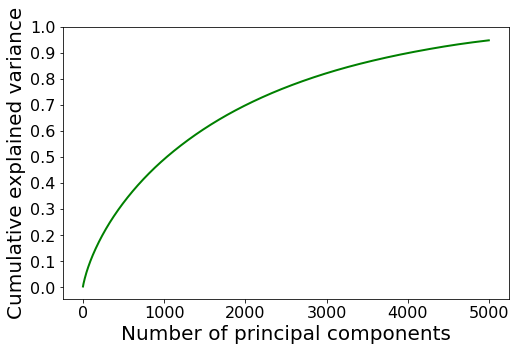

In [199]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(svd.explained_variance_ratio_), '-g')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.0,1.05,0.1))
plt.show()

In [249]:
# reconstruct
start_time = time()
#score_mat_fitted = U.dot(V) # U*V # This is slower
score_mat_fitted = svd.inverse_transform(svd.transform(util_mat))
print("Execution time: %f seconds" % (time()-start_time))

Execution time: 193.208363 seconds


In [38]:
# Recommendation
def tsvd_model(user_id, n_items = 5,user_hash_in=False, item_hash_out=True):
    '''
    Input:
        user_id: unhashed user_id
        n_items: n items to be recommended, 5 in this project.
        user_hash_in: If the input is hashed user_id (0,1,2,...). Default is False
        item_hash_out: If the output needs to be hashed item_id (0,1,2,...). Default is True
    Output:
        return recomended n_items
    '''
    if not user_hash_in: # if input is unhashed
        user_id = user_hash[user_id] # Get mapped user_id from hash table
    
    # Check if this is a cold starter (new user)
    if user_id not in list_user:
        print('This is a cold start user.')
        return list_ct
        
    pred_score = score_mat_fitted[user_id,:]
    item_index_sorted = list(np.argsort(pred_score))[::-1]
    # Ensure it is unscored
    items_scored = util_mat[user_id].nonzero()[1]
    pool_id = [item for item in item_index_sorted if item not in items_scored][:n_items]
    
    if not item_hash_out: # if unhased item_id is required
        pool_id = [item_hash_inv[i] for i in pool_id]

    return pool_id

In [39]:
user_id = user_hash_inv[200] # Pick a lucky user
tsvd_model(user_id)

[9723, 6422, 15377, 34479, 34476]

<a id='section_bm'></a>
### 3.3 Baseline recommendation model (Bonus 1) 

Based on the training data, recommend the top five most popular unscored items in the catogory that has the highest summation of 'behavior_type' with the specific user.

In [40]:
def baseline(user_id, n_items=5, user_hash_in=False, item_hash_out=True):
    '''
    This baseline model is to recommend the top five most popular unscored items in the catogory with the
    highest summation of 'behavior_type' for the specific user.
    
    Input:
        user_id: unhashed intersted user
        n_items: number of items to be recommended, 5 in this test
        user_hash_in: If the input is hashed user_id (0,1,2,...). Default is False
        item_hash_out: If the output needs to be hashed item_id (0,1,2,...). Default is True
    Output:
        recommended n_items item_id
    '''
    if not user_hash_in: # if input is unhashed
        user_id = user_hash[user_id] # Get mapped user_id from hash table
    
    # Check if this is a cold starter (new user)
    if user_id not in list_user:
        print('This is a cold start user.')
        return list_ct
    
    list_recommend = []
    # find the category for the user_id with the highest summation of behavior_type 
    baseline = df_train.groupby(['user_id','item_category'])['behavior_type'].sum()[user_id]
    category = baseline.sort_values(ascending = False).index[0] 
    
    # find most popular items in the category
    popular_item = df_train.groupby(['item_category','item_id'])['behavior_type'].sum()[category]
    
    n=0 # flag to quit
    for item in popular_item.sort_values(ascending = False).index.values:
        if util_mat[user_id, item] == 0: # make sure it is not interacted before for the user_id
            list_recommend.append(item)
            n += 1
            if n == n_items: # we only need n_items items to be recommendedxs
                break
                
    if not item_hash_out: # if unhased item_id is required
        list_recommend = [item_hash_inv[i] for i in list_recommend]
    
    return list_recommend # return unhashed item_id

<a id='section_eva'></a>
## 4. Evaluation

Use RMSE and MAE to evaluate the score for the pair of (user_id, item_id) only appear in the validation set. By processing, it shows there are 60705 pairs only in validation set. Thus we randomly select 10000 of them for evaluation with RMSE, MAE and f1 score.

For the baseline model, since the model in Part 3.3 is to give recomendation list. Here, we use average score of the user's 'behavior_type' in the training set.

In [130]:
# set: pair of user_id and item_id
start_time = time()

train_pair, val_pair = set(), set()

for _, row in df_train.iterrows():
    train_pair.add((row.user_id, row.item_id, row.behavior_type))
    
for _, row in df_val.iterrows():
    val_pair.add((row.user_id, row.item_id, row.behavior_type))
    
print("Execution time: %f seconds" % (time()-start_time))

Execution time: 26.793880 seconds


In [132]:
pair_val = val_pair - train_pair & val_pair
print('There are %i pairs only in validation set.' % len(pair_val))

There are 60705 pairs only in validation set.


In [330]:
# Randomly select 500 users from the pool
np.random.seed(0)
pair_pool = random.sample(pair_val,10000)

For the baseline model, since the model in Part 3.3 is to give recomendation list. Here, we use average score of the user's 'behavior_type' in the training set.
 <a id='section_bmave'></a>

In [332]:
cf_score, tsvd_score, baseline_score, true_score = [], [], [], []

for user_id, item_id, score in pair_pool:
    # save the predicted score
    
    ############################
    ####### Truncated SVD ######
    ############################
    tsvd_score.append(score_mat_fitted[user_id, item_id])
        
    #############################
    ####### Baseline model ######
    #############################
    base_pool = util_mat[user_id].nonzero()[1]
    base_result = util_mat[user_id, base_pool].mean()
    baseline_score.append(base_result)
    
    ######################################
    ####### Collaborative Filtering ######
    ######################################
    nb_users = knn(user_id, 100, user_sim_mat)
    # Only consider neighbor users w/ closer interaction into calculation
    candidate = np.array(util_mat[nb_users, item_id].todense()).squeeze()
    user_pool_cf = nb_users[candidate>1]
    result_cf = 0
    if len(user_pool_cf) != 0: # ensure at lease one neighbor rated the item
        deno_cf = 0 # denomintor of the score
        # calculating score
        for user in user_pool_cf:
            b_cf = user_sim_mat[user_id, user]
            a_cf = util_mat[user, item_id]
            deno_cf += b_cf
            result_cf += a_cf * b_cf
        result_cf /= deno_cf
        cf_score.append(result_cf)
    else:
        cf_score.append(base_result)
    
    #########################
    ####### True score ######
    #########################
    true_score.append(score)

In [347]:
print('Error Report:')
print('-'*40)
print('User-User Collaborative Filtering:\nMAE: %.5f, RMSE: %.5f' 
      % ((error(true_score, cf_score)[0]),error(true_score, cf_score)[1]))
print('-'*40)
print('Truncated SVD:\nMAE: %.5f, RMSE: %.5f' 
      % ((error(true_score, tsvd_score)[0]),error(true_score, tsvd_score)[1]))
print('-'*40)
print('Baseline model:\nMAE: %.5f, RMSE: %.5f' 
      % ((error(true_score, baseline_score)[0]),error(true_score, baseline_score)[1]))

Error Report:
----------------------------------------
User-User Collaborative Filtering:
MAE: 0.59216, RMSE: 0.74434
----------------------------------------
Truncated SVD:
MAE: 2.46022, RMSE: 2.66187
----------------------------------------
Baseline model:
MAE: 0.57759, RMSE: 0.70935


In [371]:
# Build dictionary with keys of users and values with items
user_dict=defaultdict(list)
for user, item, _ in pair_pool:
    user_dict[user].append(item)
# Select users with more than 10 items as the test
user_list=[]
for user, item in user_dict.items():
    if len(item)>10:
        user_list.append(user)

 <a id='section_cc'></a>

In [402]:
cf_precision, cf_recall, cf_f1 = [], [], []
base_precision, base_recall, base_f1 = [], [], []
tsvd_precision, tsvd_recall, tsvd_f1 = [], [], []

for user_id in user_list:
    cf_val, tsvd_val, base_val, true_val = [], [], [], []
    
    for item_id in user_dict[user_id]:

        ############################
        ####### Truncated SVD ######
        ############################
        tsvd_val.append(score_mat_fitted[user_id, item_id])

        #############################
        ####### Baseline model ######
        #############################
        base_pool = util_mat[user_id].nonzero()[1]
        base_result = util_mat[user_id, base_pool].mean()
        base_val.append(base_result)

        ######################################
        ####### Collaborative Filtering ######
        ######################################
        nb_users = knn(user_id, 100, user_sim_mat)
        # Only consider neighbor users w/ closer interaction into calculation
        candidate = np.array(util_mat[nb_users, item_id].todense()).squeeze()
        user_pool_cf = nb_users[candidate>1]
        result_cf = 0
        if len(user_pool_cf) != 0: # ensure at lease one neighbor rated the item
            deno_cf = 0 # denomintor of the score
            # calculating score
            for user in user_pool_cf:
                b_cf = user_sim_mat[user_id, user]
                a_cf = util_mat[user, item_id]
                deno_cf += b_cf
                result_cf += a_cf * b_cf
            result_cf /= deno_cf
            cf_val.append(result_cf)
        else:
            cf_val.append(base_result)

        #########################
        ####### True score ######
        #########################
        true_val.append(util_mat_val[user_id,item_id])

    # Precision and score
    if error(cf_val, true_val)[2] != -1:
        cf_precision.append(error(cf_val, true_val)[2])
        cf_recall.append(error(cf_val, true_val)[3])
        cf_f1.append(error(cf_val, true_val)[4])
    if error(base_val, true_val)[2] != -1:
        base_precision.append(error(base_val, true_val)[2])
        base_recall.append(error(base_val, true_val)[3])
        base_f1.append(error(base_val, true_val)[4])
    if error(tsvd_val, true_val)[2] != -1:
        tsvd_precision.append(error(tsvd_val, true_val)[2])
        tsvd_recall.append(error(tsvd_val, true_val)[3])
        tsvd_f1.append(error(tsvd_val, true_val)[4])

In [414]:
print('Mean F1 score report:')
print('-'*40)
print('Base model: %.5f' % np.nanmean(base_f1))
print('-'*40)
print('User collaborative model: %.5f' % np.nanmean(cf_f1))
print('-'*40)
print('Truncated SVD: %.5f' % np.nanmean(tsvd_f1))

Mean F1 score report:
----------------------------------------
Base model: 0.94383
----------------------------------------
User collaborative model: 0.70756
----------------------------------------
Truncated SVD: 0.46687
